# TRAPPIST-1 Simulation
## Stage I: Sequential formation & migration
### Simulation set-up
TRAPPIST-1 planet data from Huang & Ormel (2022):
<center>
<img width=500 src="./Figures/trappist1_data.png"></img>
</center>

In [2]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt

# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"
sim.random_seed = 13741154 # for reproducibility

# Add the star
sim.add(m=0.09)

# Define planet radii
r_earth = 4.264e-5
radii = np.array([1.116, 1.097, 0.788, 0.920, 1.045, 1.129, 0.755]) * r_earth

# Define planet masses
m_earth = 3.003e-6 # in solar masses
masses = np.array([1.374, 1.308, 0.388, 0.692, 1.039, 1.321, 0.326]) * m_earth

# Observed a values
# a0 = np.array([1.154, 1.580, 2.227, 2.925, 3.849, 4.683, 6.189]) * 0.01  

# Figure 3 imitation
# b_a = 1.3
# a0 = np.array([b_a, b_a*2**(2/3)*1.01, b_a*2**(4/3)*1.03, b_a*2**(4/3)*1.5**(2/3)*1.07, b_a*2**(4/3)*1.5**(4/3)*1.1, b_a*2**(4/3)*1.5**(6/3)*1.13, b_a*2**(4/3)*1.5**(8/3)*1.15]) * 0.01  
# e0 = np.array([0.004, 0.002, 0.006, 0.0065, 0.009, 0.004, 0.0035])

# b/c/d Laplace resonance 

masses = masses[0:3] # limit to b/c/d
num_planets = len(masses)

a_b = 0.045 # starting semimajor axis for planet b
P_b = a_b**(3/2)
P0 = np.array([P_b, P_b*1.5, P_b*2.25]) # start b/c/d in 3:2 and 3:2
a0 = P0**(2/3)
e0 = np.array([0.004, 0.002, 0.006])
M = np.array([0, 0, np.pi/3]) # set mean anomalies (proxy for lambda) so that they are in 
                 # Laplace resonance with libration angle 180

# Add planets 
for i in range(3): # b/c/d only
    sim.add(m=masses[i], a=a0[i], e=e0[i])

sim.move_to_com()

# Move to center of momentum
ps = sim.particles


/opt/homebrew/lib/python3.14/site-packages/reboundx/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Disk Parameters
From Huang & Ormel (2022):
<center>
<img width=400 src="./Figures/Huang_parameters.png"></img>
</center>

Depending on the model, the parameters are changed.
- In the `bC` model, $\tau_{a,\oplus}=5e3$, $C_e =0.1$, and $r_c=0.013$ (observed location of planet b).
- In the `dCcgI` model, $r_c = 0.023$ (observed location of planet d).

In [3]:
# Free parameters
tau_a_earth = 5e3
C_e = 0.1 
r_c = 0.013
A_a = 50
A_e = 1

# Other parameters
h = 0.03
M_g_dot = 10e-10
M_star = 0.09
gamma_I = 2
tau_d = 1e5
Delta = 2*h*r_c
Q_sim = 100

### Reboundx forces
We add `modify_orbits_forces` from `REBOUNDx` for damping due to planet-disk interactions and tidal dissipation.

We don't use `tides_constant_time_lag` for tidal interactions.

In [4]:
rebx = reboundx.Extras(sim)

# Planet-disk interaction
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

### Orbital Damping
We calculate the semi-major axis damping timescale and eccentricity damping timescale based on these equations from Huang & Ormel (2022):
<center>
<img width=400 src="./Figures/Huang_timescales.png"></img>
</center>

Though not computed here, note that $\Omega_K = \sqrt{\dfrac{GM_{\star}}{r^3}}$ is the Keplerian angular velocity.

In [5]:
rebx = reboundx.Extras(sim)

# Planet-disk interaction
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

q_vals = masses / M_star
q_earth =  3.003e-6 / M_star

def f_functions(r):
    # Piecewise functions f_a and f_e
    conditions = [
        r < r_c - Delta,
        (r_c - Delta <= r) & (r < r_c),
        (r_c <= r) & (r < r_c + Delta + 1 / A_a),
        r >= r_c + Delta + 1 / A_a
    ]

    f_a = [
        0,          
        A_a * (r_c - Delta - r) / Delta,
        (r-r_c)* (A_a + 1) / (Delta + 1/A_a) - (A_a), # modified to make it continuous, paper might be wrong
        1
    ]

    f_e = [
        0,          
        A_e * (r - r_c + Delta) / Delta,
        (A_e - 1) * (r_c + Delta + 1 / A_a - r) / (Delta + 1 / A_a) + 1, 
        1
    ]

    f_a_vals = np.select(conditions, f_a, default=np.nan)
    f_e_vals = np.select(conditions, f_e, default=np.nan)
    return f_a_vals, f_e_vals

%matplotlib widget
def plot_f_functions():
    fig, ax = plt.subplots()
    fig.set_figwidth(4.0)
    fig.set_figheight(4.0)

    xs = np.linspace(0, 3*r_c, 100)
    f_a_vals, f_e_vals = f_functions(xs)
    ax.plot(xs, f_a_vals, label='f_a')  
    ax.plot(xs, f_e_vals, label='f_e')  
    plt.ylabel("$f_a$ or $f_e$")
    plt.xlabel("Distance from the star")
    plt.axvline(r_c-Delta, color='gray', ls='--', alpha=0.3)
    plt.axvline(r_c, color='gray', ls='--', alpha=0.5)
    plt.axvline(r_c+Delta+1/A_a, color='gray', ls='--', alpha=0.3)
    plt.legend()
    plt.show()

# plot_f_functions()
print(r_c - Delta)
print(r_c + Delta + 1 / A_a)

0.01222
0.03378


/opt/homebrew/lib/python3.14/site-packages/rebound/simulation.py:259: RuntimeWarning: REBOUNDx overwrites sim->additional_forces, sim->pre_timestep_modifications and sim->post_timestep_modifications whenever forces or operators that use them get added.  If you want to use REBOUNDx together with your own custom functions that use these callbacks, you should add them through REBOUNDx.  See https://github.com/dtamayo/reboundx/blob/master/ipython_examples/Custom_Effects.ipynb for a tutorial.
  warnings.warn(msg[1:], RuntimeWarning)


### Tidal Damping
$k_2$ is the potential Love number of degree 2 and $\tau$ is the constant time lag parameter (note that damping occurs when $\tau$ is positive). As referenced in Papaloizou 2018, we take $k_2=0.3$ (for Solar system planets in terrestrial mass range) and
<center>
<img width=400 src="./Figures/Huang_tidal_dissipation.png"></img>
</center>

In [ ]:
def calculate_tau_e_tidal(i, planet):
    return 7.63e5 * Q_sim * (masses[i]/m_earth) * (1/M_star)**1.5 * (r_earth/radii[i])** 5 * (planet.a/0.05)**6.5

# Tidal damping, but is not used by H&O
# tides = rebx.load_force("tides_constant_time_lag")
# rebx.add_force(tides)

# ps[0].r = 0.0005534056
# ps[0].params['tctl_k2'] = 0.03
# ps[0].params['tctl_tau'] = 0.04

# Note: M_star is already in units of M_sun

### Functions for Calculating Laplace Angle
We use the formula $$\lambda = M+\varpi = M+\omega + \Omega$$ where
- $\lambda$ is the mean longitude
- $M$ is the mean anomaly
- $\varpi$ is the longitude of periapsis
- $\omega$ is the argument of periapsis
- $\Omega$ is the longitude of ascending node

In [69]:
def mean_longitude(p):
    return (p.M + p.omega + p.Omega) % (2*np.pi)

def laplace_angle(sim, i, j, k):
    ps = sim.particles
    lam_i = mean_longitude(ps[i])
    lam_j = mean_longitude(ps[j])
    lam_k = mean_longitude(ps[k])
    phi = 2*lam_i - 5*lam_j + 3*lam_k # for +2/-5/+3 Laplace resonance
    return np.mod(phi, 2*np.pi)

### Integrate and Record Stage I
We set the timestep to 5% of the orbital period of Planet b to make sure we always resolve the orbit

In [70]:
sim.dt = ps[1].P / 15 # usually 1/20 or 1/12 of innermost period
# print(sim.dt)

time_steps = 10000
data = {
    "a":           np.zeros((num_planets, time_steps)),
    "e":           np.zeros((num_planets, time_steps)),
    "n":           np.zeros((num_planets, time_steps)),
    "P":           np.zeros((num_planets, time_steps)),
    "P_ratio":     np.zeros((num_planets-1, time_steps)),
    "phi":         np.zeros(time_steps),
    "tau_a":       np.zeros((num_planets, time_steps)),
    "tau_e":       np.zeros((num_planets, time_steps)),
    "tau_e_tidal": np.zeros((num_planets, time_steps))
}

t_end = 10000 # yrs
times = np.linspace(0, t_end, time_steps)

def inject(i):
    injection_schedule = {
        30: 2,
        60: 3,
        90: 4,
        120: 5,
        150: 6
    }
    if i in injection_schedule:
        idx = injection_schedule[i]
        sim.add(m=masses[idx], a=a0[idx], e=e0[idx])
        sim.move_to_com()
        ps = sim.particles

In [ ]:
def add_years(years=1000, time_steps=1000):
    return

for i, t in enumerate(times):
    sim.integrate(t)
    # inject(i)
    
    current_a_vals = np.array([p.a for p in sim.particles[1:]])
    f_a_vals, f_e_vals = f_functions(current_a_vals)
    
    # a damping
    for j, p in enumerate(ps[1:]): # b = 0, c = 1, etc.
        current_tau_a = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j] # negative so it is damping   
        if j == 6:   # h
            p.params["tau_a"] = current_tau_a 
        elif j == 5: # g
            p.params["tau_a"] = current_tau_a
        elif j == 2: # d
             p.params["tau_a"] = current_tau_a
        elif j == 1: # c
             p.params["tau_a"] = current_tau_a
        elif j == 0: # b
             p.params["tau_a"] = current_tau_a
            
        if p.params["tau_a"] == -np.inf: # not in gas disk (in r_c or too far out)
            p.params["tau_a"] = -1e32

    # e damping
    for j, p in enumerate(ps[1:]):
        current_tau_e = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
        if j == 6:   # h
            p.params["tau_e"] = current_tau_e
        elif j == 5: # g
            p.params["tau_e"] = current_tau_e
        else:
            p.params["tau_e"] = -1000 # do -1000
            # p.params["tau_e"] = current_tau_e
            
    # tidal dissipation
    for j, p in enumerate(ps[1:]):
        p.params['tctl_tau'] = calculate_tau_e_tidal(j, p)  # really large numbers
        # print(p.params['tctl_tau'])
            
    # Record data    
    for j, p in enumerate(ps[1:]):  # skip the star
        data["a"][j, i] = p.a
        data["e"][j, i] = p.e
        data["n"][j, i] = p.n
        data["P"][j, i] = p.P
        # data["tau_a"][j, i] = p.params["tau_a"]
        # data["tau_e"][j, i] = p.params["tau_e"]
        # data["tau_e_tidal"][j, i] = p.params["tctl_tau"]
    for j, p in enumerate(ps[1:num_planets]): # num_planets-1 ratios
        data["P_ratio"][j, i] = data["P"][j+1, i] / data["P"][j, i]
    data["phi"][i] = laplace_angle(sim, 1, 2, 3) # b,c,d

1130844382.1446285
6797885007.870888
61102920499.03218
1122678539.6734786
6854461782.106896
61168996016.21733
1116832312.0428164
6894078674.761953
61422769198.02548
1122704676.7693238
6828711946.623891
62035517521.55137
1125096874.9753194
6791508894.174803
62734061048.68596
1118775504.875934
6844028607.547515
62795794950.85428
1116910790.7465377
6871194211.421155
62397299664.15846
1126009195.9578822
6806844754.170307
61992071716.18216
1127844695.9683614
6782242445.065487
62261480498.942566
1120774645.3567019
6825627584.233223
62970163620.30145
1116060344.9661634
6859590910.770079
63107153143.19215
1124563183.9929118
6800070291.228649
62565368805.962105
1127951131.8128295
6786661186.880361
62024251286.04001
1119941954.8732445
6846988117.792413
62232145392.63728
1115844767.0923762
6870019023.158024
62708280149.81742
1123399849.986728
6800745808.131137
62954022752.79109
1125110238.2267213
6796375002.923005
62509281218.4257
1119194186.1046185
6866586702.013661
61747126525.91694
1120234434.

/opt/homebrew/lib/python3.14/site-packages/rebound/simulation.py:259: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator. See REBOUNDx paper sec 5.1.
  warnings.warn(msg[1:], RuntimeWarning)


1119678908.5425618
6839786842.664853
62600969032.20954
1125828885.3579705
6779783443.897315
62931728824.76357
1126221874.5887144
6767342483.54887
63381496699.7462
1117964970.3790827
6846781914.170486
62900581893.31629
1118433790.8414364
6852824872.071011
62489259982.643005
1126918628.7673523
6774592079.507007
62831685141.97004
1125803552.7048213
6782851093.84576
62809632961.03902
1118675271.9091403
6860848809.793265
62136497175.28846
1122804253.7164369
6848337171.567531
61533398352.3751
1126939508.118969
6813650489.936506
61263323344.0549
1122428434.8915362
6846662641.343886
61495255121.938736
1116523151.3018048
6875927915.445878
62225924967.347145
1124390611.6464164
6789374275.317794
63024434645.60471
1128403015.4410272
6758422696.935499
62985298146.23649
1120409211.348098
6833031591.684666
62604726440.21642
1115992816.8965137
6867745783.821634
62697973861.92623
1124198381.7236822
6794140032.512197
62962532333.02489
1126485504.485722
6780053082.276355
62712970179.33421
1121274259.1643

In [72]:
add_years(1000, 1000)

### Save Stage I Simulation to Disk

In [73]:
# sim.save_to_file("stage_i.bin")
# sim = None # Remove reference, allow python to release memory

# # Save arrays to a .npz file
# np.savez_compressed('trappist1_stage_i.npz', arr0=a_vals, arr1=e_vals, arr2=n_vals, arr3=P_vals, arr4=P_ratios,
#                                              arr5=stage_i_time_steps, arr6=stage_i_times, arr7=stage_i_end)

## Stage II: b and c migrate into cavity

In [74]:
# # Load from Stage I
# sim = rebound.Simulation("stage_I.bin")
# loaded = np.load('trappist1_stage_i.npz')
# a_vals, e_vals, n_vals, P_vals, P_ratios = loaded['arr0'], loaded['arr1'], loaded['arr2'], loaded['arr3'], loaded['arr4']
# stage_i_time_steps, stage_i_times, stage_i_end = loaded['arr5'], loaded['arr6'], loaded['arr7']

In [75]:
# stage_ii_time_steps = 7500 
# stage_ii_end = 30000 # yrs

# stage_ii_times = np.linspace(stage_i_end, stage_ii_end, stage_ii_time_steps)
# times = np.append(stage_i_times, stage_ii_times)

# # extends the arrays for data
# nans_to_add = np.full((num_planets, stage_ii_time_steps), np.nan)

# # a_vals = np.concatenate((a_vals, nans_to_add), axis=1) # axis 1 for horizontal concat
# e_vals = np.concatenate((e_vals, nans_to_add), axis=1)
# n_vals = np.concatenate((n_vals, nans_to_add), axis=1)
# P_vals = np.concatenate((P_vals, nans_to_add), axis=1)

# nans_to_add = np.full((num_planets-1, stage_ii_time_steps), np.nan)
# P_ratios = np.concatenate((P_ratios, nans_to_add), axis=1) # axis 1 for horizontal concat

### Integrate and Record Stage II

In [76]:
# for i, t in enumerate(stage_ii_times, start=stage_i_time_steps):
#     sim.integrate(t)
        
#     for j, p in enumerate(ps[1:]):  # skip the star
#         a_vals[j, i] = p.a
#         e_vals[j, i] = p.e
#         n_vals[j, i] = np.sqrt(sim.G * ps[0].m / p.a**3) 
#         P_vals[j, i] = 2 * np.pi / n_vals[j, i]
#     for j, p in enumerate(ps[1:7]):  # first 6 planet pairs
#         P_ratios[j, i] = P_vals[j+1, i] / P_vals[j, i]
        
#     f_a_vals, f_e_vals = f_functions(a_vals[:, i])
#     for j, p in enumerate(ps[1:]):
#         if j == 6: # Planet h
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j] # negative so it is damping      
#             # print(f"h tau_a: {p.params['tau_a']}")    
#         elif j == 5: # Planet g
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]
            
#             p.params["tau_a"] *= 2 # divide tau_a for g by 2 to prevent overaggressive plowing
#             # print(f"g tau_a: {p.params['tau_a']}")    
        
#         elif j == 1: # Planet c
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]
#             p.params["tau_a"] *= -15 # to make it negative and gentle
#             # print(f"c tau_a: {p.params['tau_a']}")    
#         else:
#             p.params["tau_a"] = 1e32 # turns off migration
            
#         if p.params["tau_a"] == -np.inf:
#             p.params["tau_a"] = 1e32 # turns off migration

#     for j, p in enumerate(ps[1:]): # skip star at index 0
#         if j == 6: # Planet h
#             p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
#             # print(f"h tau_e: {p.params['tau_e']}")    
#         elif j == 5: # Planet g
#             p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
#             # print(f"g tau_e: {p.params['tau_e']}")    
#         p.params["tau_e"] = -100 

## Stage III: Long Term Tidal Dissipation

### Changing parameters
We change $Q_{sim}=0.1$ to accelerate the sim by $10^3$ times. 

The disk torque term is ignored.

Disk repulsion

Sims that apply tidal torques on b only or b and c only are consistent with on all planets

In [77]:
# Q_sim = 0.1

# stage_iii_time_steps = 5000 
# stage_iii_end = 30000 # yrs
# stage_iii_times = np.linspace(stage_ii_end, stage_iii_end, stage_iii_time_steps)
# times = np.append(times, stage_iii_times)

# # extends the arrays for data
# nans_to_add = np.full((num_planets, stage_iii_time_steps), np.nan)

# a_vals = np.concatenate((a_vals, nans_to_add), axis=1) # axis 1 for horizontal concat
# e_vals = np.concatenate((e_vals, nans_to_add), axis=1)
# n_vals = np.concatenate((n_vals, nans_to_add), axis=1)
# P_vals = np.concatenate((P_vals, nans_to_add), axis=1)

# nans_to_add = np.full((num_planets-1, stage_iii_time_steps), np.nan)
# P_ratios = np.concatenate((P_ratios, nans_to_add), axis=1) # axis 1 for horizontal concat

In [78]:
# for i, t in enumerate(stage_iii_times, start=stage_ii_time_steps):
#     sim.integrate(t)
        
#     for j, p in enumerate(ps[1:]):  # skip the star
#         a_vals[j, i] = p.a
#         e_vals[j, i] = p.e
#         n_vals[j, i] = np.sqrt(sim.G * ps[0].m / p.a**3) 
#         P_vals[j, i] = 2 * np.pi / n_vals[j, i]
#     for j, p in enumerate(ps[1:7]):  # first 6 planet pairs
#         P_ratios[j, i] = P_vals[j+1, i] / P_vals[j, i]
        
#     f_a_vals, f_e_vals = f_functions(a_vals[:, i])
#     for j, p in enumerate(ps[1:]):
#         if j == 6: # Planet h
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j] # negative so it is damping      
#             # print(f"h tau_a: {p.params['tau_a']}")    
#         elif j == 5: # Planet g
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]
            
#             p.params["tau_a"] *= 2 # divide tau_a for g by 2 to prevent overaggressive plowing
#             # print(f"g tau_a: {p.params['tau_a']}")    
        
#         elif j == 2: # Planet c
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]
#             p.params["tau_a"] *= -15 # to make it negative and gentle
#             # print(f"c tau_a: {p.params['tau_a']}")    
#         else:
#             p.params["tau_a"] = 1e32 # turns off migration
            
#         if p.params["tau_a"] == -np.inf:
#             p.params["tau_a"] = 1e32 # turns off migration

#     for j, p in enumerate(ps[1:]): # skip star at index 0
#         if j == 6: # Planet h
#             p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
#             # print(f"h tau_e: {p.params['tau_e']}")    
#         elif j == 5: # Planet g
#             p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
#             # print(f"g tau_e: {p.params['tau_e']}")    
#         p.params["tau_e"] = -100 

## Plotting semi-major axis and eccentricity evolution

/var/folders/r5/xnlv0tmn7ksdm1crp04xgqv40000gn/T/ipykernel_93426/2330999351.py:12: RuntimeWarning: divide by zero encountered in log
  ax4.plot(times, np.log(data["tau_a"][j]), label=f'{chr(98+j)}')
/var/folders/r5/xnlv0tmn7ksdm1crp04xgqv40000gn/T/ipykernel_93426/2330999351.py:13: RuntimeWarning: divide by zero encountered in log
  ax5.plot(times, np.log(data["tau_e"][j]), label=f'{chr(98+j)}')


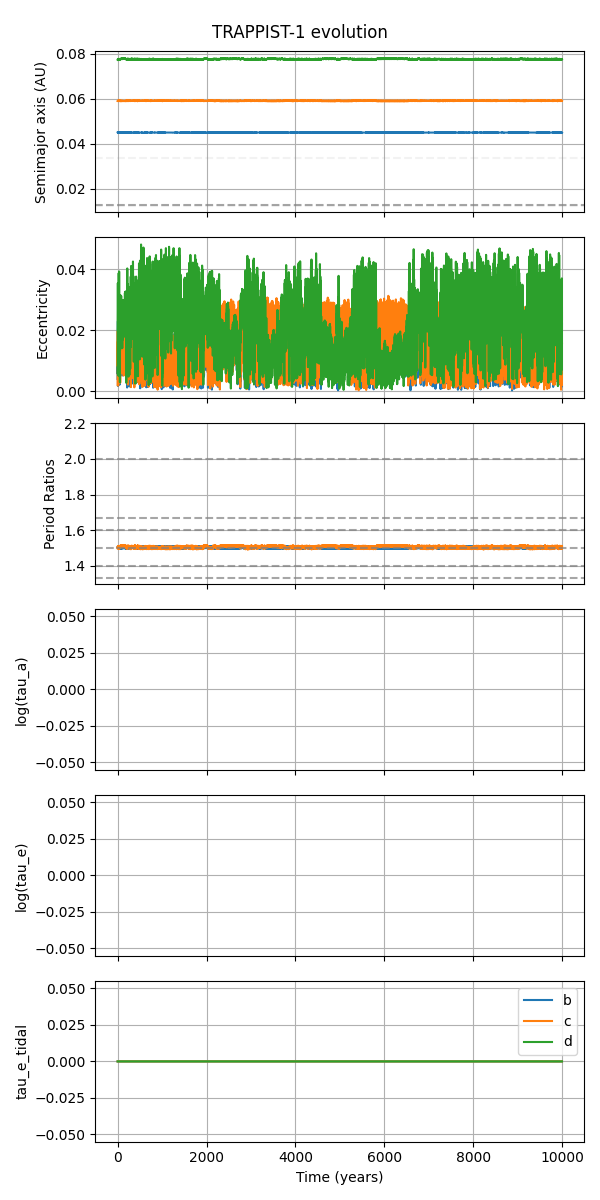

In [79]:
%matplotlib widget

def plot_trappist1():
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True)
    fig.set_figwidth(6.0)
    fig.set_figheight(12.0)

    for j in range(len(masses)):
        # could also try plotting log
        ax1.plot(times, data["a"][j], label=f'{chr(98+j)}')  # b, c, d, ...
        ax2.plot(times, data["e"][j], label=f'{chr(98+j)}')  
        ax4.plot(times, np.log(data["tau_a"][j]), label=f'{chr(98+j)}')  
        ax5.plot(times, np.log(data["tau_e"][j]), label=f'{chr(98+j)}')  
        ax6.plot(times, data["tau_e_tidal"][j], label=f'{chr(98+j)}')  
        
    plt.xlabel("Time (years)")
    ax1.set_ylabel("Semimajor axis (AU)")
    ax2.set_ylabel("Eccentricity")
    ax3.set_ylabel("Period Ratios")
    ax4.set_ylabel("log(tau_a)")
    ax5.set_ylabel("log(tau_e)")
    ax6.set_ylabel("tau_e_tidal")
    
    # Period ratios
    ratio_labels = [f"{chr(98+j-1)}+{chr(98+j)}" for j in range(1, num_planets)]  # b,c,d,...
    for j in range(num_planets-1):
        ax3.plot(times, data["P_ratio"][j], label=ratio_labels[j])
    # Add horizontal lines for nearby resonances
    resonances = [2, 8/5, 7/5, 5/3, 3/2, 4/3]
    for r in resonances:
        ax3.axhline(r, color='gray', ls='--', alpha=0.7)
    
    # ax1.set_ylim(0.005, 0.13)
    # ax2.set_ylim(-0.01, 0.3)
    ax3.set_ylim(1.3, 2.2)

    # Plot truncation radius 
    ax1.axhline(r_c, color='gray', ls='--', alpha=0.7)
    ax1.axhline(r_c - Delta, color='gray', ls='--', alpha=0.1)
    ax1.axhline(r_c + Delta + 1/A_a, color='gray', ls='--', alpha=0.1)

    # # Stage indicators
    # for stage in [stage_i_end, stage_ii_end, stage_iii_end]:
    #     ax1.axvline(stage, color='gray', ls='--', alpha=0.7)
    #     ax2.axvline(stage, color='gray', ls='--', alpha=0.7)

    fig.subplots_adjust(hspace=0)

    plt.suptitle("TRAPPIST-1 evolution")
    ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True)
    plt.legend(); plt.tight_layout(); plt.show()

plot_trappist1()

### Resonance Ratios

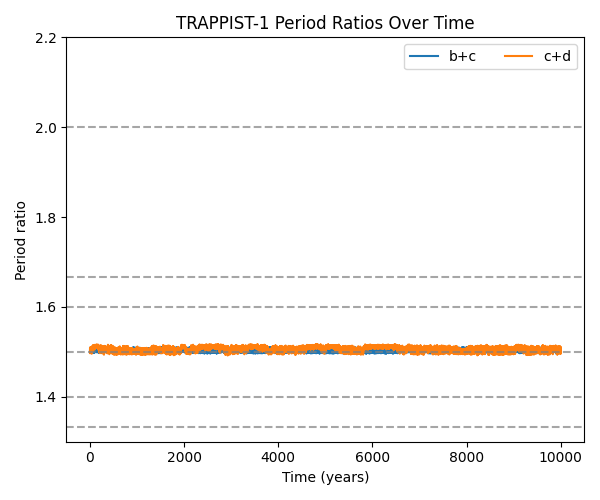

In [80]:
plt.figure(figsize=(6,5))
labels = [f"{chr(98+j-1)}+{chr(98+j)}" for j in range(1, num_planets)]  # b,c,d,...
for j in range(num_planets-1):
    plt.plot(times, data["P_ratio"][j], label=labels[j])

# Add horizontal lines for nearby resonances
resonances = [2, 8/5, 7/5, 5/3, 3/2, 4/3]
for r in resonances:
    plt.axhline(r, color='gray', ls='--', alpha=0.7)

# # Stage indicators
# for stage in [stage_i_end, stage_ii_end, stage_iii_end]:
#     plt.axvline(stage, color='gray', ls='--', alpha=0.7)

plt.xlabel("Time (years)")
plt.ylabel("Period ratio")
plt.ylim(1.3, 2.2)
plt.title("TRAPPIST-1 Period Ratios Over Time")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


### Laplace Angles

<>:5: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:6: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
<>:5: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:6: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
/var/folders/r5/xnlv0tmn7ksdm1crp04xgqv40000gn/T/ipykernel_93426/2973308569.py:5: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  plt.ylabel("Laplace angle $\phi$ (degrees)")
/var/folders/r5/xnlv0tmn7ksdm1crp04xgqv40000gn/T/ipykernel_93426/2973308569.py:6: SyntaxWarning: "\l" is an inva

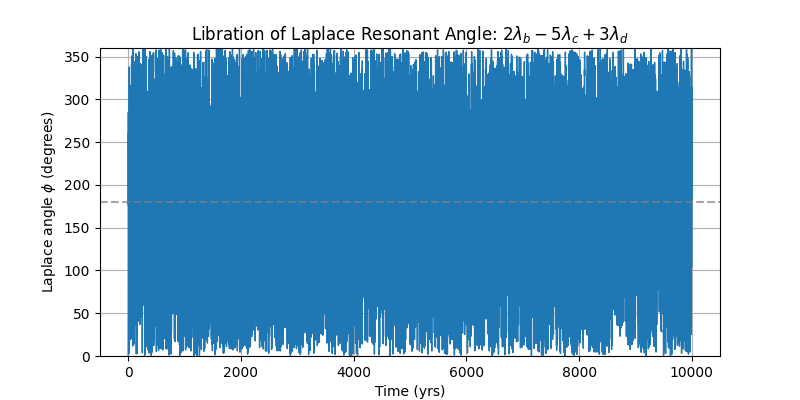

In [81]:
plt.figure(figsize=(8,4))
plt.plot(times, np.rad2deg(data["phi"]), lw=1)
plt.axhline(180, color='gray', ls='--', alpha=0.7)
plt.xlabel("Time (yrs)")
plt.ylabel("Laplace angle $\phi$ (degrees)")
plt.title("Libration of Laplace Resonant Angle: $2\lambda_b - 5\lambda_c + 3\lambda_d$")
plt.ylim(0,360)
plt.grid(True)
plt.show()

### 3BR Angles

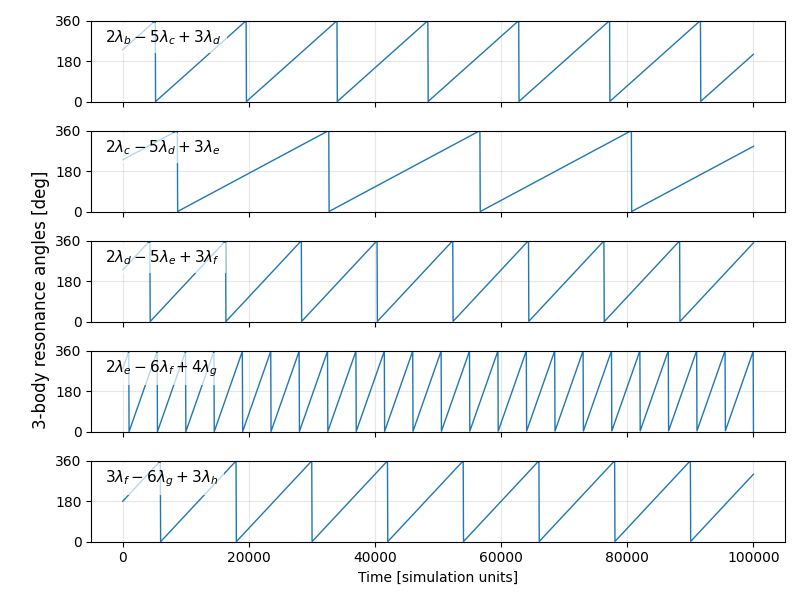

In [82]:
# Example: assume you have arrays of mean longitudes (lambda)
# for planets b, c, d, e, f, g, h over time.
# Replace these with your simulation data.
time = np.linspace(0, 1e5, 2000)  # simulation time, e.g. in years
lambda_b = (0.02 * time) % 360
lambda_c = (0.03 * time + 50) % 360
lambda_d = (0.045 * time + 100) % 360
lambda_e = (0.06 * time + 150) % 360
lambda_f = (0.08 * time + 200) % 360
lambda_g = (0.11 * time + 250) % 360
lambda_h = (0.15 * time + 300) % 360

# Define the 3-body resonance angles
phi1 = (2*lambda_b - 5*lambda_c + 3*lambda_d) % 360
phi2 = (2*lambda_c - 5*lambda_d + 3*lambda_e) % 360
phi3 = (2*lambda_d - 5*lambda_e + 3*lambda_f) % 360
phi4 = (2*lambda_e - 6*lambda_f + 4*lambda_g) % 360
phi5 = (3*lambda_f - 6*lambda_g + 3*lambda_h) % 360

phis = [phi1, phi2, phi3, phi4, phi5]
labels = [
    r"$2\lambda_b - 5\lambda_c + 3\lambda_d$",
    r"$2\lambda_c - 5\lambda_d + 3\lambda_e$",
    r"$2\lambda_d - 5\lambda_e + 3\lambda_f$",
    r"$2\lambda_e - 6\lambda_f + 4\lambda_g$",
    r"$3\lambda_f - 6\lambda_g + 3\lambda_h$"
]

# Function to center at 180 (so y runs from 0 to 360)
def wrap180(angle):
    return (angle + 180) % 360 - 180

fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(time, wrap180(phis[i]) + 180, lw=1)
    
    # Label inside top-left corner
    ax.text(0.02, 0.90, labels[i],
            transform=ax.transAxes,
            fontsize=11, fontweight='bold',
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    ax.set_ylim(0, 360)
    ax.set_yticks([0, 180, 360])
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time [simulation units]")
fig.text(0.04, 0.5, "3-body resonance angles [deg]", va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()
